# Model Training

In this colab notebook, we are training our heatmap model. We will first preprocess the input image using inception_v3 into a vector representation with 2048 attributes. Using this vector, we attempt to define a model that decodes the vector into the heatmap corresponding to this particular image

## Import Packages

In [0]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [0]:
from google.colab import drive
from PIL import Image

In [0]:
from sklearn.model_selection import train_test_split


In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Input, Flatten
from tensorflow.keras.models import Sequential, Model

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
drive.mount('/gdrive')
train_path = '/gdrive/My Drive/images/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## Preprocess Inputs

In [0]:
def image_activate(image_path):
    im = tf.io.read_file(image_path)
    im = tf.image.decode_jpeg(im, channels = 3)

    im = tf.image.resize(im, (500, 500))
    acti = tf.keras.applications.inception_v3.preprocess_input(im)
    return acti, image_path

In [0]:
set_image_path = set()

In [0]:
for filename in os.listdir(train_path):
  if filename[6:10] != 'mask' and 'npy' not in filename:
    set_image_path.add(os.path.join(train_path, filename))

In [0]:
image_model = tf.keras.applications.InceptionV3(input_shape=(500,500,3),
                                                include_top=False,
                                                pooling='max',
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 6s 0us/step


In [0]:
acti_d = tf.data.Dataset.from_tensor_slices(list(set_image_path))
acti_d = activation_dataset.map( image_activate, 
  num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(64)

In [0]:
for img_batch, path_batch in acti_d:
  batch_features = image_features_extract_model(img_batch)
  for hg, p in zip(batch_features, path_batch):
    
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, hg.numpy())  

OSError: ignored

## Divide dataset into training and testing

A couple of things to note:
- Make sure the zipped activations and masks are in the colab directory

In [0]:
!unzip activations.zip
!unzip masks.zip

Archive:  activations.zip
   creating: content/activations/
  inflating: content/activations/train_12295.png.npy  
  inflating: content/activations/train_10316.png.npy  
  inflating: content/activations/train_1641.png.npy  
  inflating: content/activations/train_14004.png.npy  
  inflating: content/activations/train_921.png.npy  
  inflating: content/activations/train_16083.png.npy  
  inflating: content/activations/train_12651.png.npy  
  inflating: content/activations/train_7230.png.npy  
  inflating: content/activations/train_4668.png.npy  
  inflating: content/activations/train_17515.png.npy  
  inflating: content/activations/train_7504.png.npy  
  inflating: content/activations/train_11627.png.npy  
  inflating: content/activations/train_7580.png.npy  
  inflating: content/activations/train_14316.png.npy  
  inflating: content/activations/train_10170.png.npy  
  inflating: content/activations/train_13786.png.npy  
  inflating: content/activations/train_13405.png.npy  
  inflating:

In [0]:
activations_path = 'content/activations'
masks_path = 'content/masks'

files = os.listdir(masks_path)

acti_inp = []
mask_outputs = []
for filename in files:
  activation_file = filename.split("mask_")[0] + filename.split("mask_")[1] + '.npy'
  activation_inputs.append(os.path.join(activations_path, activation_file))
  mask_outputs.append(os.path.join(masks_path, filename))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(acti_inp, mask_outputs, train_size=0.8)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5)

In [0]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

16799 16799
2100 2100
2100 2100


## Defining our model

In [0]:
decoder_input = Input(shape=(2048,))

x = Dense(625, activation='relu')(decoder_input)

x = Reshape((25, 25, 1))(x)

x = Conv2DTranspose(128, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2DTranspose(128, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2DTranspose(64, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2DTranspose(64, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)
                    

x = Conv2D(1, 3, padding='same', activation='softmax')(x)

dmodel = Model(decoder_input, x)


In [0]:
print(dmodel.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 625)               1280625   
_________________________________________________________________
reshape_2 (Reshape)          (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 50, 50, 128)       1280      
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 100, 100, 128)     147584    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 200, 200, 64)      73792     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 400, 400, 64)      3692

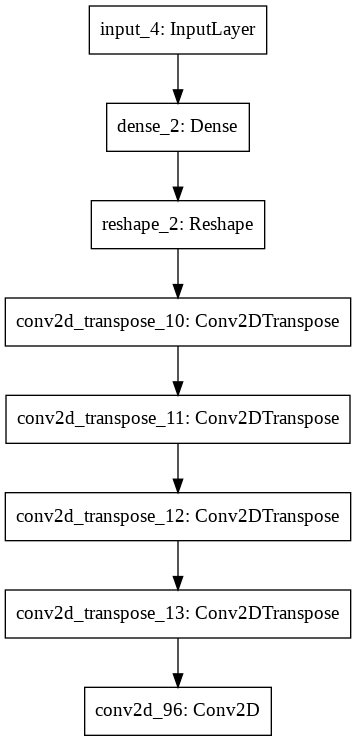

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model.png')

In [0]:
dmodel.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

## Model Training

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

In [0]:
def evaluate(max_steps=None):
  steps = 0
  for i in range(len(X_val)):
    inputi = np.load(X_val[i])
    b = np.array(Image.open(y_val[i]).convert('L'))[:400,:400]

    norm_ans = (b-30)/(215-30)
    predictions = decoder_model.predict(inputi.reshape(1,2048))
    
    steps += 1 

    b = norm_ans.reshape(1,400,400,1)
    
    val_loss(b, predictions)
    val_accuracy(b, predictions)



In [0]:
import time 
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []
epochs = 5 
for epoch in range(epochs):

  start = time.time()
  for j in range(525):
    elements = np.random.randint(len(X_train), size=32)
    X_batch, y_batch = [], []
    for yay in elements:   
      X_batch.append(np.load(X_train[e]))
      masked_img = np.array(Image.open(y_train[yay]).convert('L'))[:400,:400]
      norm_img = (masked_img-30)/(215-30)
      y_batch.append(norm_img)
    result = dmodel.train_on_batch(np.array(X_batch), np.array(y_batch))

    train_loss(result[0])
    train_accuracy(result[1])


  evaluate(max_steps=100)

  printingstuff = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(printingstuff.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  

  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)


  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()


Epoch 0, Loss: 0.21, Accuracy: 92.57, Val Loss 0.18, Val Accuracy 93.07, Time: 280.5 secs
Epoch 1, Loss: 0.16, Accuracy: 93.44, Val Loss 0.15, Val Accuracy 94.32, Time: 274.5 secs
Epoch 2, Loss: 0.14, Accuracy: 94.51, Val Loss 0.15, Val Accuracy 94.39, Time: 274.9 secs
Epoch 3, Loss: 0.13, Accuracy: 94.63, Val Loss 0.14, Val Accuracy 94.33, Time: 277.3 secs
Epoch 4, Loss: 0.12, Accuracy: 94.86, Val Loss 0.13, Val Accuracy 94.71, Time: 275.0 secs


content/activations/train_1966.png.npy
(400, 400, 4)
[[4.2858905e-05 3.8638511e-05 3.6651702e-05 ... 9.5808864e-06
  1.2421135e-05 4.5864441e-04]
 [3.8167331e-05 3.4017132e-05 3.5518802e-05 ... 8.7385415e-06
  9.4763682e-06 3.6614301e-04]
 [3.3847504e-05 3.4215784e-05 3.8049006e-05 ... 9.6387885e-06
  9.1747106e-06 3.4571745e-04]
 ...
 [2.4087359e-04 2.4862069e-04 2.5587319e-04 ... 1.9461675e-05
  2.2566568e-05 7.6707383e-04]
 [2.4027353e-04 2.6103648e-04 2.5660268e-04 ... 2.5697729e-05
  3.1846987e-05 1.0292557e-03]
 [3.5799542e-03 1.7641902e-03 1.8822012e-03 ... 9.8267384e-04
  1.4659655e-03 6.8266666e-03]]


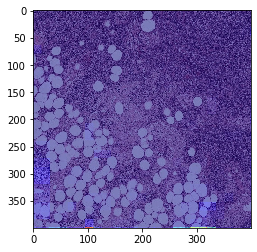

In [0]:
img = np.array(Image.open(os.path.join(train_path,'train_1966.png')))[:400,:400]
inpi = np.load(X_test[22])


print(X_test[22])
ans = np.array(Image.open(y_test[22]).convert('L'))[:400,:400]
norm_ans = (ans-30)/(215-30)
predictions = decoder_model.predict(inpi.reshape(1,2048)).reshape(400,400)

print(img.shape)
print(predictions)
plt.imshow(img)
plt.imshow(predictions, cmap='jet', alpha=0.5)
plt.show()

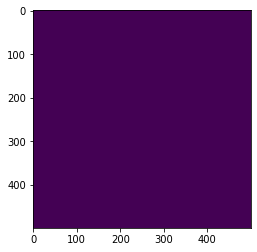

In [0]:
corr_mask = Image.open(os.path.join(masks_path,'train_mask_1966.png'))
plt.imshow(corr_mask)